In [391]:
import pandas as pd
import numpy as np
from scipy import stats # For in-built method to get PCC
import scipy
from sklearn.model_selection import KFold
import pingouin as pg
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from zca import zca
import seaborn as sns
import sklearn.linear_model
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.tools
import matplotlib.pyplot as plt
zca = zca.ZCA()

In [395]:
target = 'Poverty'

all_data = pd.read_csv('../data/raw/states.csv')

scaler.fit(np.array(all_data[target]).reshape(-1, 1))

StandardScaler()

In [396]:
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)
kfold.get_n_splits(all_data.index)

10

In [397]:
table = np.zeros(shape=(len(all_data.columns[1:]),1))

for train_index, test_index in kfold.split(all_data):
    subset = all_data.iloc[train_index]
    #subset = all_data.loc[:, ~all_data.columns.isin([target,'States'])]
    subset = all_data.iloc[train_index]
    n=len(subset)
    dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
    p = pd.DataFrame(2*dist.cdf(-abs(subset.pcorr()[target])))
    temp = pd.DataFrame(p.T)
    temp.columns = list(all_data.columns[1:])
    #print(temp.T.loc[np.array(temp.T<=.05)])
    table = (table + np.where(temp.T<=.05, 1, 0)).copy()
    #table.append(temp.T<=.05)
    #print(temp.T<=.05)
    
temp = pd.DataFrame(table.T)
temp.columns = list(all_data.columns[1:])
temp


,Poverty,Infant Mort,White,Crime,Doctors,Traf Deaths,University,Unemployed,Income,Population
0,10.0,1.0,10.0,1.0,0.0,10.0,0.0,9.0,10.0,8.0


In [398]:
threshold = .5
chosen = list(temp.T.loc[np.array(temp.T>=(num_folds*threshold))].index[1:])
dataSet = pd.concat([all_data[target],all_data[chosen]],axis=1)
t1 = pd.DataFrame(scaler.transform(np.array(dataSet[target]).reshape(-1, 1)))
t1.columns=[target]


In [399]:
zca_data = pd.concat([t1,pd.DataFrame(zca.fit_transform(dataSet[chosen]),columns=chosen)],axis=1)

In [401]:
zca_data.pcorr()

,Poverty,White,Traf Deaths,Unemployed,Income,Population
Poverty,1.000000,-0.611186,0.207474,0.390783,-0.921306,0.365956
White,-0.611186,1.000000,0.126803,0.238841,-0.563089,0.223667
Traf Deaths,0.207474,0.126803,1.000000,-0.081081,0.191147,-0.075926
Unemployed,0.390783,0.238841,-0.081081,1.000000,0.360031,-0.143009
Income,-0.921306,-0.563089,0.191147,0.360031,1.000000,0.337157
Population,0.365956,0.223667,-0.075926,-0.143009,0.337157,1.000000


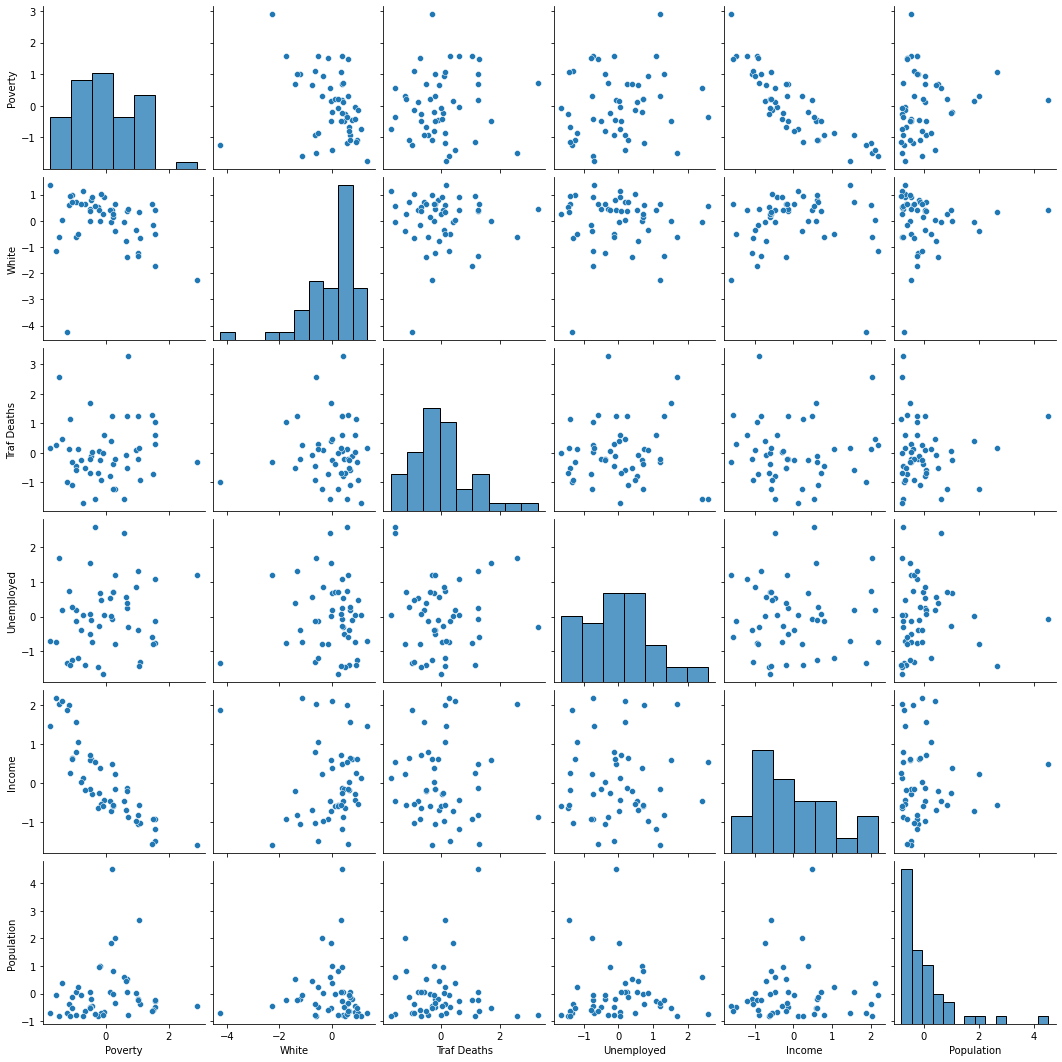

In [402]:
sns.pairplot(zca_data)

In [403]:

#model = sklearn.linear_model.LinearRegression()
data_set_wConstant = statsmodels.tools.tools.add_constant(zca_data)
y = data_set_wConstant[target]
X = data_set_wConstant[data_set_wConstant.columns.drop(target)]
#results = model.fit(X, y)
model = sm.OLS(y,X)
results = model.fit()

In [384]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Poverty   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     57.99
Date:                Sun, 25 Jul 2021   Prob (F-statistic):           2.97e-18
Time:                        19:59:46   Log-Likelihood:                -20.276
No. Observations:                  50   AIC:                             52.55
Df Residuals:                      44   BIC:                             64.02
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.743e-16      0.055    1.6e-14      1.000      -0.110       0.110
White          -0.2831      0.055     -5.122      0.000      -0.395      -0.172
Traf Deaths     0.0778      0.055      1.407      0.167      -0.034       0.189
Unemployed      0.1557      0.055      2.816      0.007       0.044       0.267
Income         -0.8688      0.055    -15.717      0.000      -0.980      -0.757
Population      0.1442      0.055      2.608      0.012       0.033       0.256
==============================================================================
Omnibus:                        2.493   Durbin-Watson:                   1.791
Prob(Omnibus):                  0.287   Jarque-Bera (JB):                2.333
Skew:                           0.509   Prob(JB):                        0.311
Kurtosis:                       2.714   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

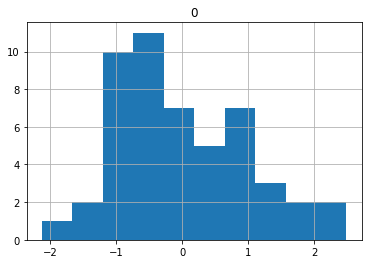

In [387]:
pd.DataFrame(results.get_influence().resid_studentized_internal).hist()

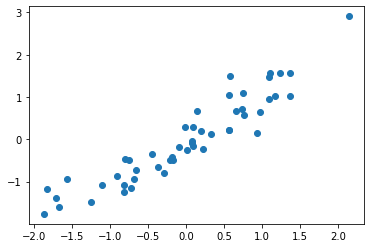

In [392]:
plt.scatter(results.fittedvalues, y)